# Construct synthetic sequences and look at how the core CTCF motif interacts with the TA motif

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from util import import_shap_scores, import_peak_table, import_profiles, import_tfmodisco_results
from util import trim_motif_by_ic
from util import figure_to_vdom_image
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm

import sys
sys.path.append('/home/katie/bp_repo/multitask_profile_model_SPI_GATA/')
from plotting_helper import *
from all_functions import *
from profile_models import ModelLoader

import random
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

plt.rcParams["figure.dpi"] = 130

### a) Generate a set of 100 random sequence backgrounds

In [2]:
# set seed for reproducibility
rng = np.random.default_rng(2022)

In [3]:
# generate random sequence backgrounds
seqs = []
alphabet = ['A','C','G','T']

for i in range(100):
    seqs.append(''. join(rng.choice(alphabet) for _ in range(2114)))

### b) Insert the CTCF motif and the TA motif in the center of the sequences, and pass them through the model, averaging the prediction over all 100 sequences

In [4]:
core_motif = 'CCACCAGGGGG'
ta_motif = 'TA'

In [8]:
# load in model
controls = True
model = ModelLoader('/home/katie/bp_repo/pipeline_outputs/ctcf_chipseq_feb7/' + 'model.state_dict', controls=controls, num_tasks=1).load_model()

In [18]:
def avg_preds_at_distance(distance, seqs, model):
    ''' given a distance between core motif and TA motif, along with 100 random background seqs
        and a model, insert motifs at appropriate distance in each seq, then calculate predictions 
        for each seq, then average predictions across all 100 seqs
    '''
    core_insertion_index = 2114 // 2 - 10 - distance // 2 #  - 10 can change to something else
    ta_insertion_index = core_insertion_index + len(core_motif) + distance
    
    original_seqs = seqs.copy()  # just to be careful with memory and overriding stuff
    # insert motifs 
    for i in range(len(original_seqs)):
        seq = original_seqs[i]
        assert core_motif not in seq
        original_seqs[i] = seq[:core_insertion_index] + core_motif + seq[core_insertion_index + len(core_motif):ta_insertion_index] + \
        ta_motif + seq[ta_insertion_index + len(ta_motif):]

    original_seqs = dna_to_one_hot(original_seqs)   # so you end up with one-hot encoded seqs
    original_seqs = torch.from_numpy(original_seqs).float()
    original_seqs = original_seqs.cuda(device=device, non_blocking=True)
    
    # get predictions
    with torch.no_grad():
        if controls:
            cont_profs = torch.zeros((100, 1, 1000, 2)).cuda()  # CHANGE THIS IS MORE THAN 1 TASK, other issues etc.
            logit_pred_profs, log_pred_counts = model(original_seqs, cont_profs)
        else:
            logit_pred_profs, log_pred_counts = model(original_seqs)
    logit_pred_profs = logit_pred_profs.detach().cpu().numpy()  # go back to cpu
    log_pred_counts = log_pred_counts.detach().cpu().numpy()
    log_pred_profs = profile_logits_to_log_probs(logit_pred_profs)
    
    # average across all 100 seqs; THESE ARE ALREADY EXPONENTIATED, NO LOG!! also removes the 1st dimension!!
    avg_pred_profs = np.mean(np.exp(log_pred_profs), axis=0) 
    avg_pred_counts = np.mean(np.exp(log_pred_counts), axis=0) 
    
    return avg_pred_profs, avg_pred_counts

### c) Vary the distance between the CTCF motif and the TA motif. How does the profile shape change as the distance changes (show animation)?

In [19]:
all_avg_pred_profs, all_avg_pred_counts = [], []
for distance in range(0,1000,10):
    avg_pred_profs, avg_pred_counts = avg_preds_at_distance(distance, seqs, model)
    all_avg_pred_profs.append(avg_pred_profs)
    all_avg_pred_counts.append(avg_pred_counts)

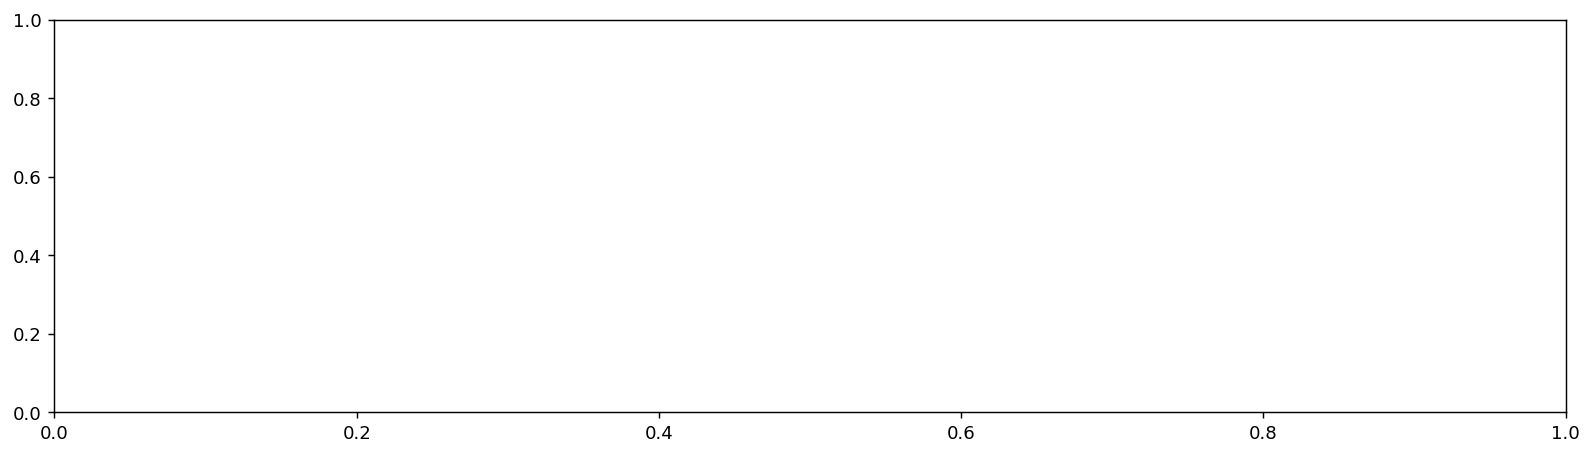

In [20]:
fig, ax = plt.subplots(1, figsize=(15, 4))

def animate(i):
    plt.clf()
    avg_pred_profs = all_avg_pred_profs[i]
    avg_pred_counts = all_avg_pred_counts[i]
    
    pred_profs = avg_pred_profs * avg_pred_counts
    
    ax.clear()
    plt.setp(ax, xlim=(0, 1000), ylim=(-1, 1))

    ax.plot(pred_profs[0,:,0], color="royalblue")
    ax.plot(-pred_profs[0,:,1], color="goldenrod")
    
    # this shtuff doesn't work vvvv :/
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    # plt.title('Live graph with matplotlib')

anim = FuncAnimation(fig, animate, frames=100)

In [21]:
HTML(anim.to_jshtml())

<Figure size 780x520 with 0 Axes>

In [309]:
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

### e) How does the total counts change as the distance changes?

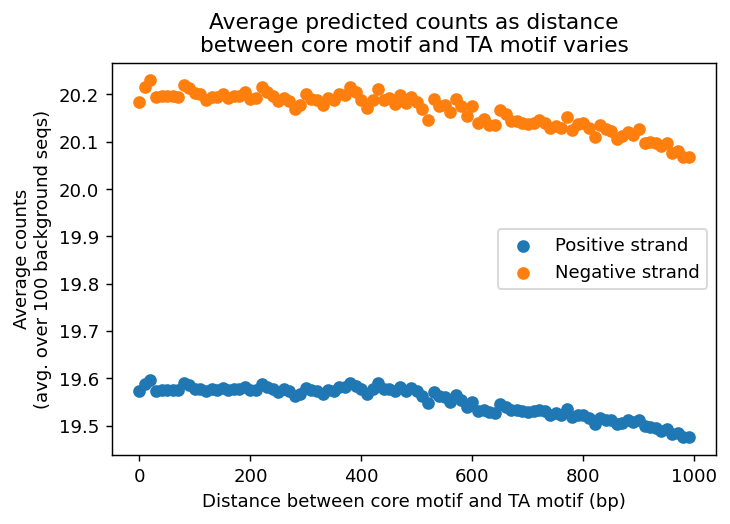

In [184]:
fig, ax = plt.subplots()
ax.scatter(list(i * 10 for i in range(100)), list(i[0][0] for i in all_avg_pred_counts), label='Positive strand')
ax.scatter(list(i * 10 for i in range(100)), list(i[0][1] for i in all_avg_pred_counts), label='Negative strand')

plt.xlabel('Distance between core motif and TA motif (bp)')
plt.ylabel('Average counts\n(avg. over 100 background seqs)')
plt.title('Average predicted counts as distance\nbetween core motif and TA motif varies')

ax.legend()